In [10]:
from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc
from pyshtools.expand import SHExpandGLQ
import numpy as np

import cartopy.crs as ccrs

import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

import xarray as xr

In [31]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

# Analyze how well the diffusion and other ML models reproduce the spectral content of the weather (z_500 in our case).

Code credit for spectral analysis: Mariana Clare.

- Ideally the analysis should be rerun with highres runs (so that the differences in frequencies are more apparent in the images) + fully converged runs

# look at temperature!

In [11]:
runs_configs = {
    "diffusion": ("rasp_thuerey_z_500_3day",  "diffusion", "2023-09-13_19-47-27", "2023-09-14_09-45-42"),
    "diffusion_10Members": ("rasp_thuerey_z_500_3day",  "diffusion", "2023-09-13_19-47-27", "2023-09-14_10-29-54"),
    "diffusion_CosineAnnealing": ("rasp_thuerey_z_500_3day",  "diffusion_CosineAnnealing", "2023-09-13_22-56-04", "2023-09-14_09-51-06"),
    "diffusion_deeper": ("rasp_thuerey_z_500_3day",  "diffusion_deeper", "2023-09-13_20-06-24", "2023-09-14_09-46-02"),
    "diffusion_wider": ("rasp_thuerey_z_500_3day",  "diffusion_wider", "2023-09-13_20-04-33", "2023-09-14_09-46-01"),
    "diffusion_MSE_Loss": ("rasp_thuerey_z_500_3day",  "diffusion_MSE_Loss", "2023-09-13_21-22-12", "2023-09-14_09-52-21"),
    "diffusion_2csteps": ("rasp_thuerey_z_500_3day_2csteps",  "diffusion_2csteps", "2023-09-13_22-18-16", "2023-09-14_10-09-09"),
    "diffusion_more_patient_deeper": ("rasp_thuerey_z_500_3day",  "diffusion_more_patient_deeper", "2023-09-14_14-38-48", "2023-09-15_15-44-47"),
    "diffusion_z_500_3day_highres": ("rasp_thuerey_highres_z_500_3day",  "diffusion_z_500_3day_highres", "2023-09-16_19-25-33", "2023-09-16_21-05-32"),
}

predictions = dict()
targets = dict()
diff = dict()

for key, r_config in runs_configs.items():
    targets[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format(*r_config))
    predictions[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format(*r_config))
    diff[key] = targets[key] - predictions[key]

# predictions_unet = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format("rasp_thuerey_highres_z_500_3day", "unet_highres", "2023-09-14_16-53-47","2023-09-16_15-46-38"))
# targets_unet = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format("rasp_thuerey_highres_z_500_3day", "unet_highres", "2023-09-14_16-53-47","2023-09-16_15-46-38"))


predictions_unet = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format("rasp_thuerey_z_500_3day", "unet", "2023-09-09_18-26-54","2023-09-13_20-55-01"))
targets_unet = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format("rasp_thuerey_z_500_3day", "unet", "2023-09-09_18-26-54","2023-09-13_20-55-01"))

In [12]:
target_field = targets["diffusion_more_patient_deeper"].z_500.values
predictions_field = predictions["diffusion_more_patient_deeper"].z_500.values
predictions_unet_field = predictions_unet.z_500.values

In [13]:
compute_weighted_rmse(predictions_unet.isel({"ensemble_member": 0}), targets_unet.isel({"ensemble_member": 0}))

<xarray.Dataset>
Dimensions:          ()
Coordinates:
    ensemble_member  int64 0
Data variables:
    z_500            float64 562.4

In [14]:
compute_weighted_rmse(predictions["diffusion_more_patient_deeper"].isel({"ensemble_member": 0}), targets["diffusion_more_patient_deeper"].isel({"ensemble_member": 0}))

<xarray.Dataset>
Dimensions:          ()
Coordinates:
    ensemble_member  int64 0
Data variables:
    z_500            float64 595.1

In [15]:
def compute_spectra(field):
    field = np.array(field)

    # compute real and imaginary parts of power spectra of field
    # field should be 2d
    coeffs_field = SHExpandGLQ(field)

    # Re**2 + Im**2
    coeff_amp = coeffs_field[0,:,:]**2 + coeffs_field[1,:,:]**2

    # sum over meridional direction
    spectra = np.sum(coeff_amp,axis=0)

    return spectra

In [16]:
target_field.shape

(1, 2903, 1, 32, 64)

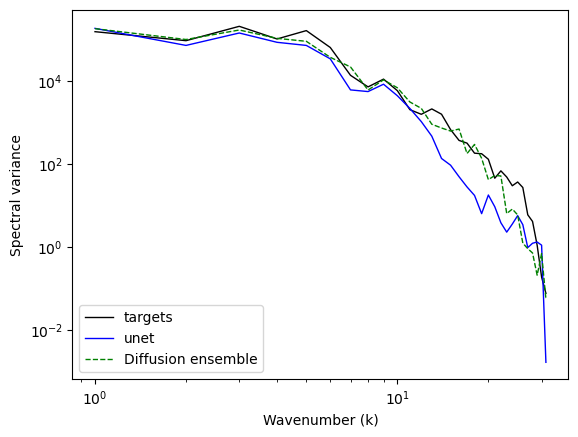

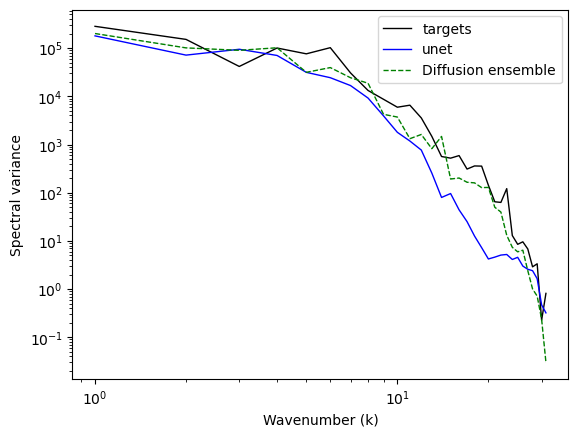

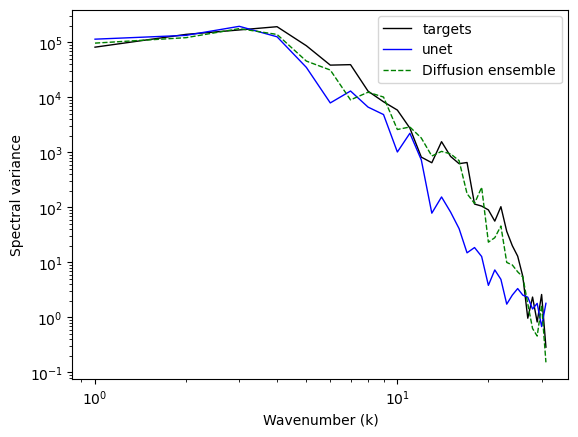

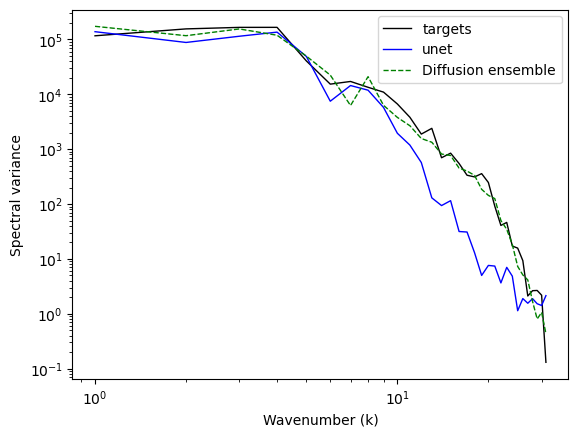

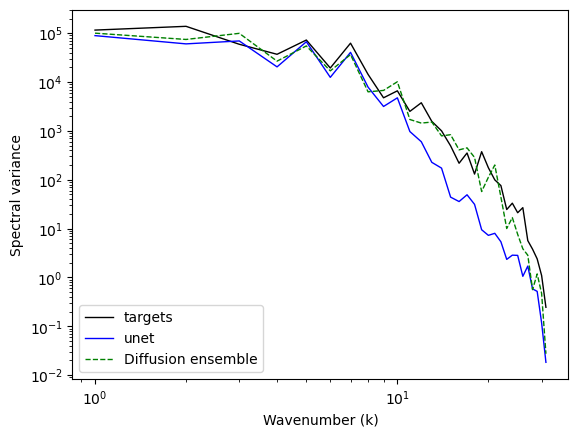

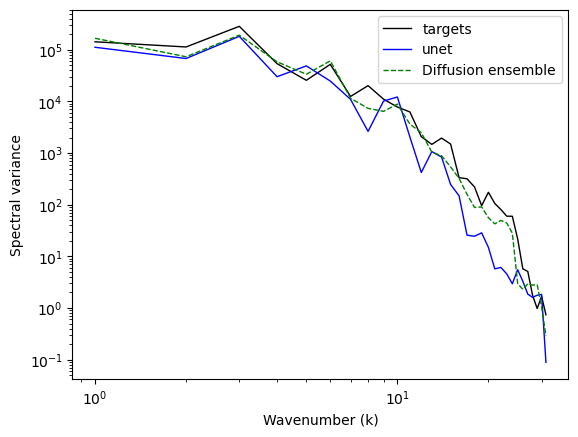

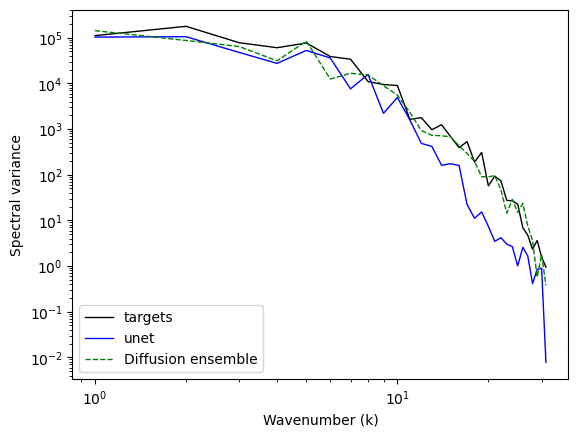

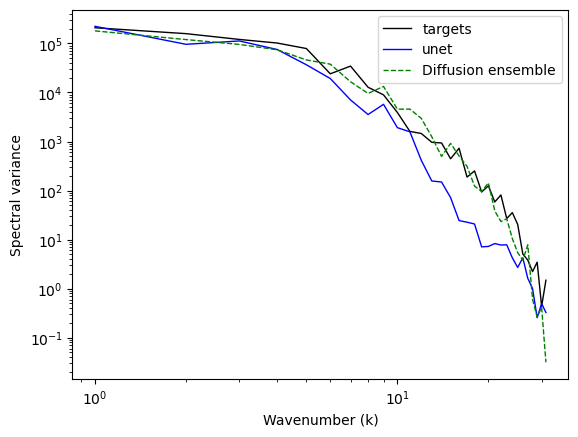

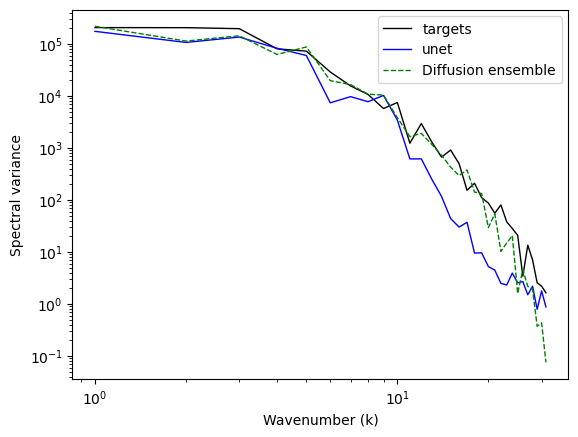

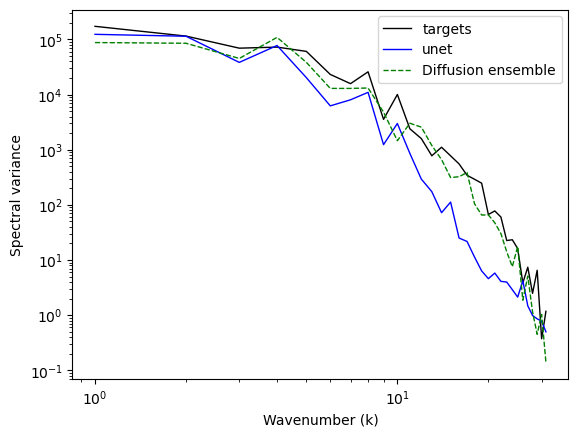

In [17]:
random_timesteps = np.random.choice(np.arange(target_field.shape[1]), size=10)

for ts in random_timesteps:
    ens_arr = target_field[:,ts,0,...]  # your ensemble array here
    num_ens_mem = target_field.shape[0] # number of members in your ensemble
    spectra_targets = []
    for i in range(num_ens_mem):
        spectra_targets.append(compute_spectra(ens_arr[i]))

    ens_arr = predictions_unet_field[:,ts,0,...]  # your ensemble array here
    num_ens_mem = predictions_unet_field.shape[0] # number of members in your ensemble
    spectra_unet_predictions = []
    for i in range(num_ens_mem):
        spectra_unet_predictions.append(compute_spectra(ens_arr[i]))

    ens_arr = predictions_field[:,ts,0,...]  # your ensemble array here
    num_ens_mem = predictions_field.shape[0] # number of members in your ensemble
    spectra_predictions = []
    for i in range(num_ens_mem):
        spectra_predictions.append(compute_spectra(ens_arr[i]))


    fig, ax = plt.subplots()

    ax.loglog(np.arange(1, spectra_targets[0].shape[0]), [np.mean(spectra_targets, axis = 0)[j] for j in np.arange(1,spectra_targets[0].shape[0])],"k", linewidth = 1, label = 'targets')
    ax.loglog(np.arange(1, spectra_unet_predictions[0].shape[0]), [np.mean(spectra_unet_predictions, axis = 0)[j] for j in np.arange(1,spectra_unet_predictions[0].shape[0])],"b", linewidth = 1, label = 'unet')

    for i in range(num_ens_mem):
        ax.loglog(np.arange(1, spectra_predictions[0].shape[0]), spectra_predictions[i][1:spectra_predictions[0].shape[0]], 'g--', linewidth = 0.1)

    ax.loglog(np.arange(1, spectra_predictions[0].shape[0]), [np.mean(spectra_predictions, axis = 0)[j] for j in np.arange(1,spectra_predictions[0].shape[0])],"g--", linewidth = 1, label = 'Diffusion ensemble')

    plt.xlabel('Wavenumber (k)')
    plt.ylabel("Spectral variance")
    plt.legend()
    plt.show()

In [21]:
spectra_targets = np.zeros(shape=(target_field.shape[1],32))
spectra_unet_predictions = np.zeros(shape=(predictions_unet_field.shape[1],32))
spectra_predictions = np.zeros(shape=(predictions_unet_field.shape[1],predictions_field.shape[0],32))

for ts in range(target_field.shape[1]):
    ens_arr = target_field[:,ts,0,...]  # your ensemble array here
    spectra_targets[ts, :] = compute_spectra(ens_arr[0])

    ens_arr = predictions_unet_field[:,ts,0,...]  # your ensemble array here
    num_ens_mem = predictions_unet_field.shape[0] # number of members in your ensemble
    spectra_unet_predictions[ts, :] = compute_spectra(ens_arr[0])

    ens_arr = predictions_field[:,ts,0,...]  # your ensemble array here
    num_ens_mem = predictions_field.shape[0] # number of members in your ensemble
    for i in range(num_ens_mem):
        spectra_predictions[ts, i, :] = compute_spectra(ens_arr[i])

In [22]:
spectra_targets = [np.mean(spectra_targets, axis=0)]
spectra_predictions = [np.mean(spectra_predictions, axis=(0,1))]
spectra_unet_predictions = [np.mean(spectra_unet_predictions, axis=0)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


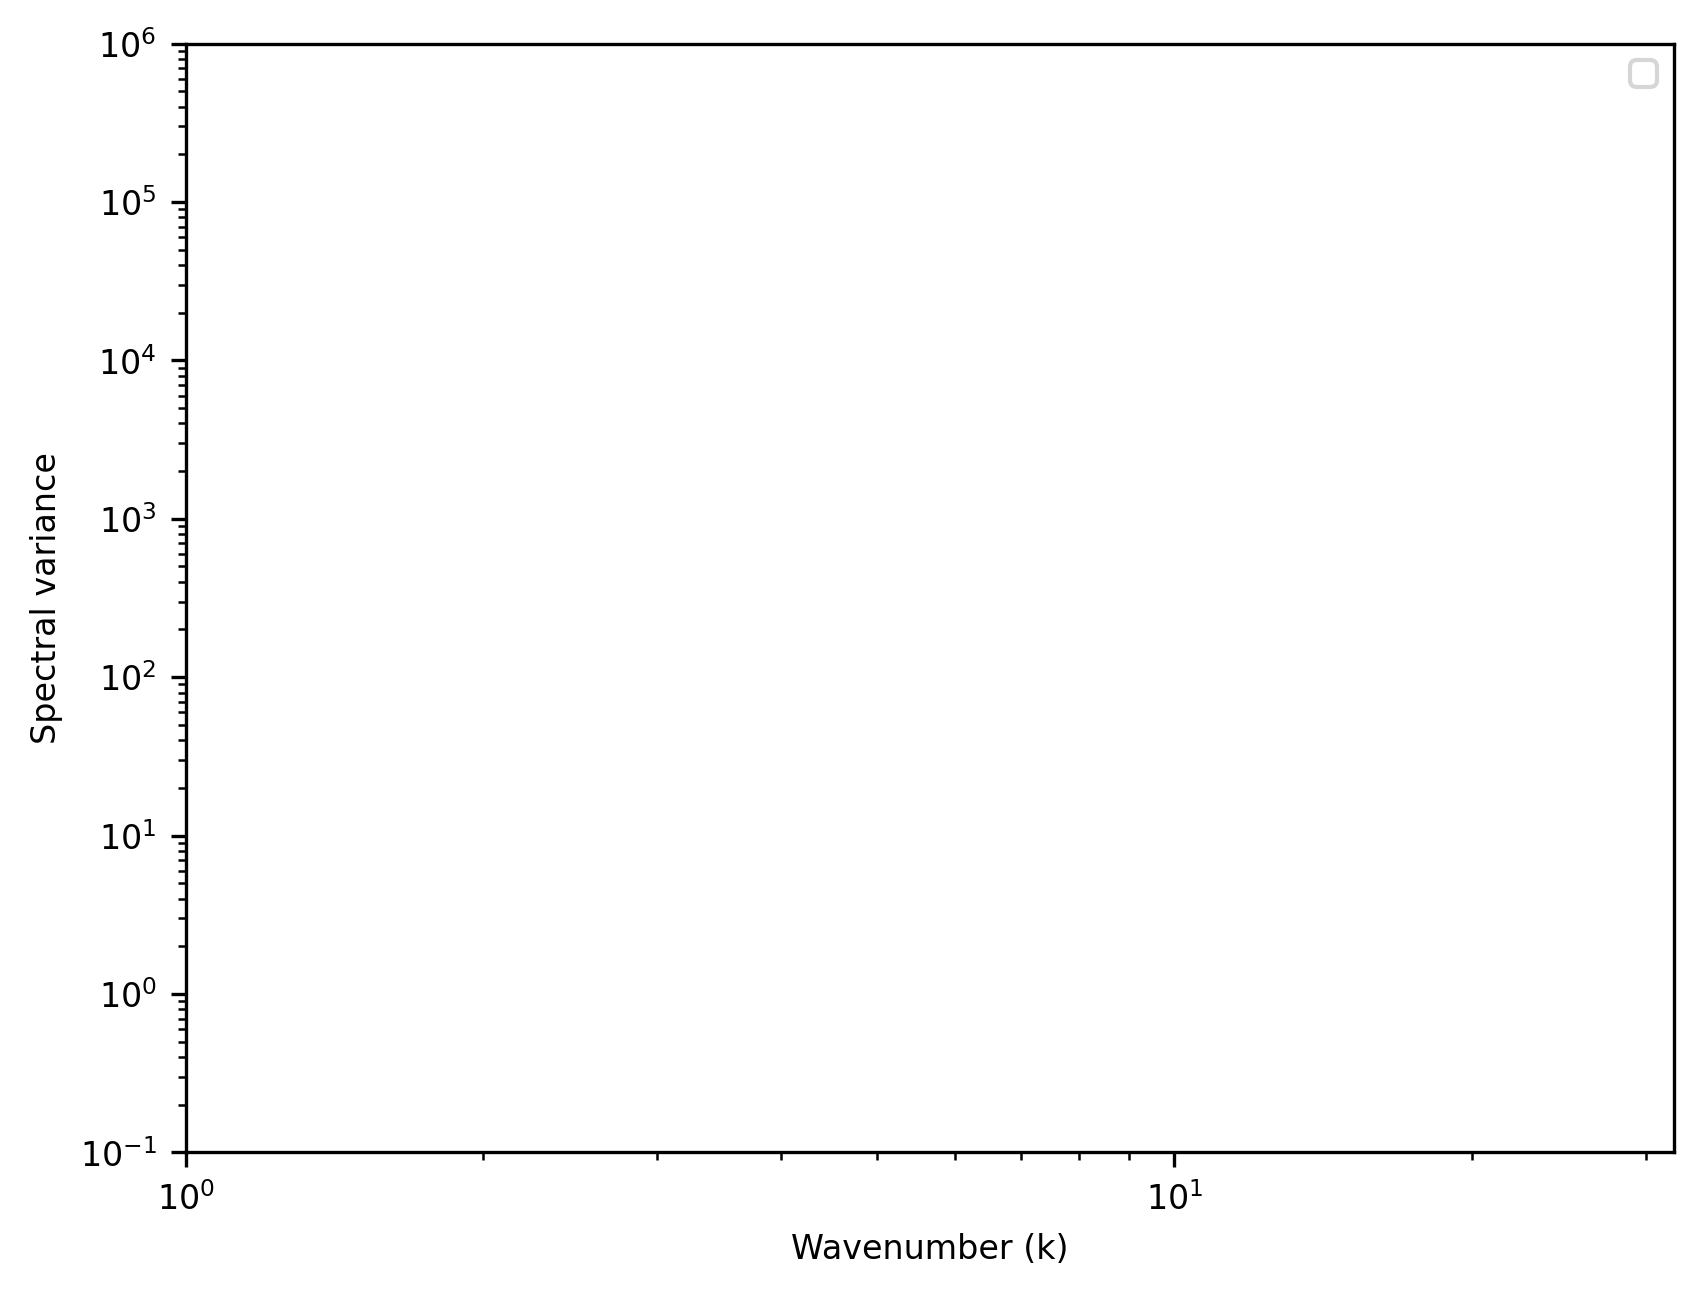

In [40]:
fig, ax = plt.subplots()

# ax.plot(np.arange(1, spectra_targets[0].shape[0]), [np.mean(spectra_targets, axis = 0)[j] for j in np.arange(1,spectra_targets[0].shape[0])],"k", linewidth = 1, label = 'targets')


# ax.plot(np.arange(1, spectra_unet_predictions[0].shape[0]), [np.mean(spectra_unet_predictions, axis = 0)[j] for j in np.arange(1,spectra_unet_predictions[0].shape[0])],"b", linewidth = 1, label = 'unet')

# ax.plot(np.arange(1, spectra_predictions[0].shape[0]), [np.mean(spectra_predictions, axis = 0)[j] for j in np.arange(1,spectra_predictions[0].shape[0])],"g--", linewidth = 1, label = 'Diffusion ensemble')

ax.set_xlim(1,32)
ax.set_ylim(1e-1, 1e6)
ax.set_yscale("log")
ax.set_xscale("log")

plt.xlabel('Wavenumber (k)')
plt.ylabel("Spectral variance")
plt.legend()
plt.savefig("images/spectra_no_entries.png")
plt.show()

#### Plot one each:

In [20]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

In [21]:
# do configurations for plotting - these can also be shared or "inherited" for plots that are similar!

config = {
    "CMAP": "viridis",
    "NORM": matplotlib.colors.Normalize(vmin=49000, vmax=59000),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": False,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": False,
    "CBAR_LABEL": r"Geopotential [$m^2/s^2$]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 6/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "RdBu"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-3000, vmax=3000)

In [22]:
n_images = 2

timesteps = np.random.choice(np.arange(len(predictions_unet["init_time"])), size=(n_images,))

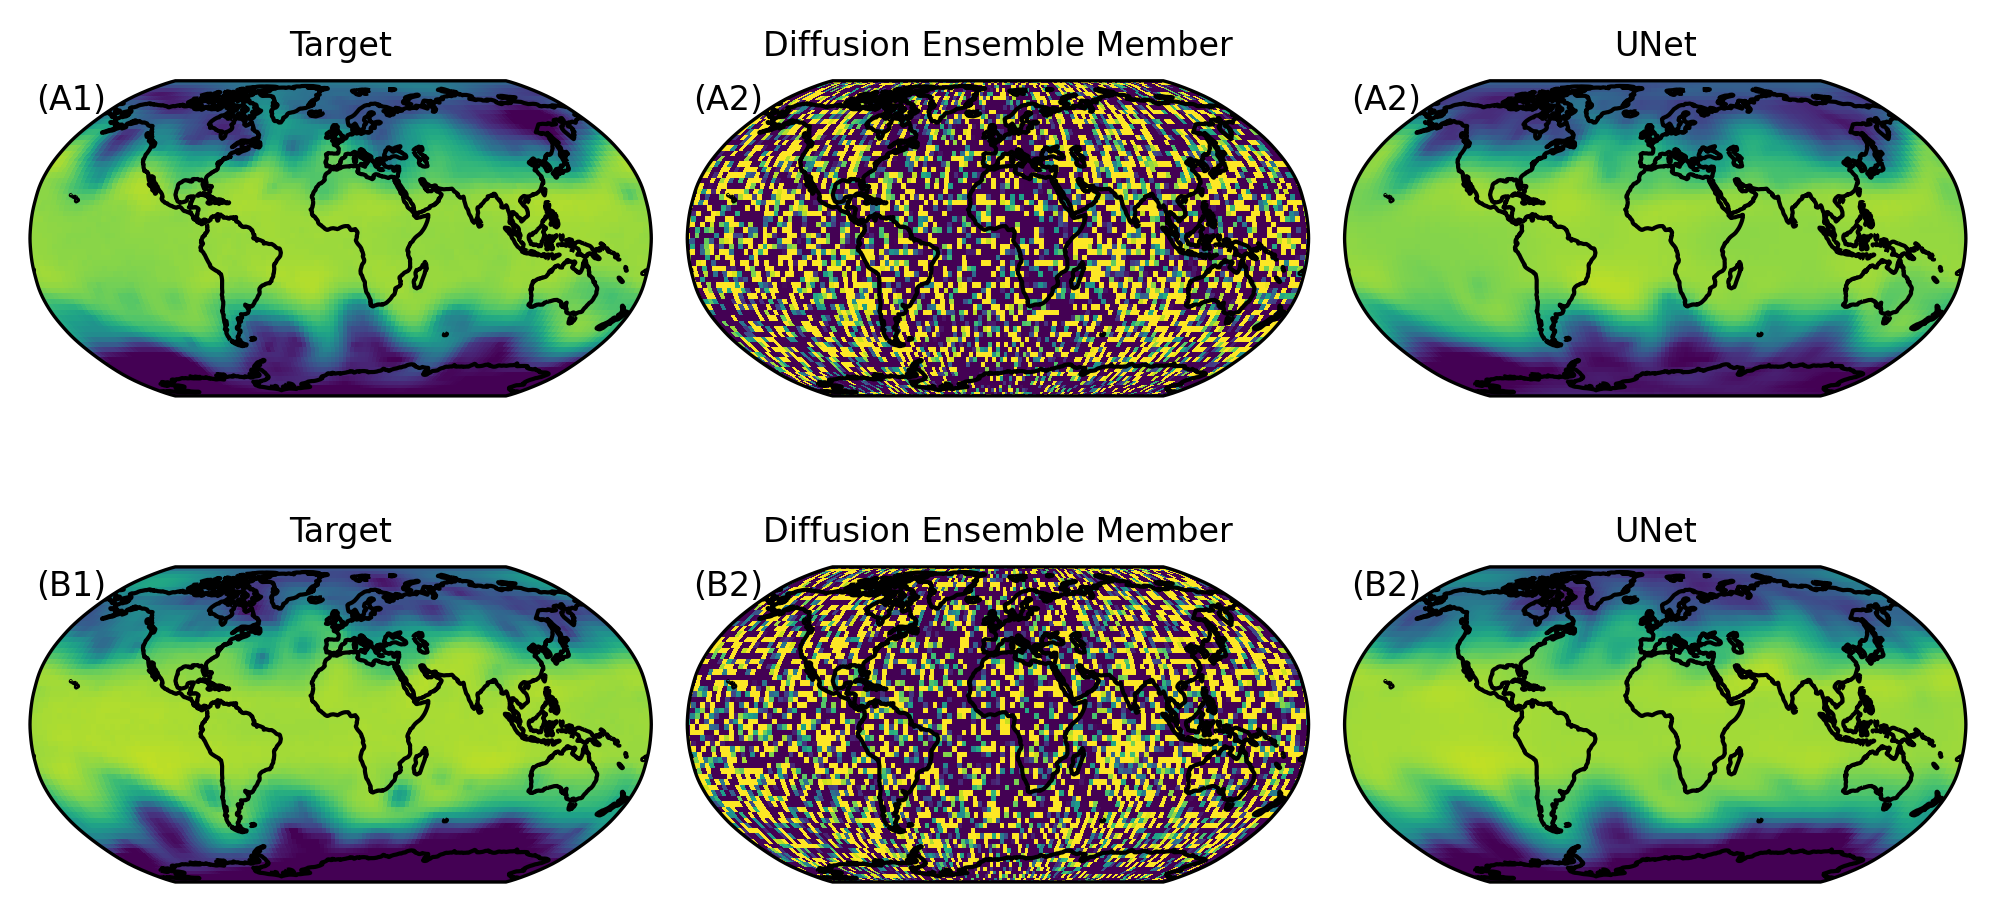

In [25]:
n_rows = n_images
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1,1,1])

for i, i_t in enumerate(timesteps):
    ax = fig.add_subplot(gs[i, 0], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=targets["diffusion_z_500_3day_highres"].isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[["z_500"]], plotting_config=config, title="Target")
    # add a label to the panel of the plot:
    add_label_to_axes(ax, "({}1)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 1], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions["diffusion_z_500_3day_highres"].isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[["z_500"]], plotting_config=config, title="Diffusion Ensemble Member")
    # add a label to the panel of the plot:
    add_label_to_axes(ax, "({}2)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 2], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions_unet.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[["z_500"]], plotting_config=config, title="UNet")
    # add a label to the panel of the plot:
    add_label_to_axes(ax, "({}2)".format(alphabet_letters[i]))
    
fig.canvas.draw()
fig.tight_layout()

plt.show()